In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys

from torch import device

sys.path.append("..")

In [8]:
# 加载训练数据
mnist_train = torchvision.datasets.FashionMNIST(
    root='~/Datasets/FashionMNIST',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

In [9]:
# 加载测试数据
mnist_test = torchvision.datasets.FashionMNIST(
    root='~/Datasets/FashionMNIST',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [10]:
def get_fashion_mnist_labels(labels):
    '''返回Fashion-MNIST数据集的文本标签'''
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [11]:
def show_fashion_mnist(images, labels):
    '''展示图像和标签'''
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

In [12]:
print(mnist_train.data.shape)
'''
60000个样本
每个样本大小28*28=784
'''
print(len(mnist_train.targets.unique()))
'''
10个标签
'''

torch.Size([60000, 28, 28])
10


'\n10个标签\n'

# 1、根据助教提供的代码框架（实验八.ipynb），完成基于softmax回归的多类别分类，补充代码框架中的soft_max、cross_entropy和accuracy。

In [17]:
class SoftMaxRegression:
    def __init__(self):
        # 初始化模型参数
        self.num_inputs = 784
        self.num_outputs = 10

        self.W = torch.normal(0, 0.01, size=(self.num_inputs, self.num_outputs), requires_grad=True) #每一个像素点的回归系数
        self.b = torch.zeros(self.num_outputs, requires_grad=True) #偏置项

    def soft_max(self, X):
        """   计算softmax
        输入: X, 其中size=(n, 10)

        对每一行X计算softmax

        输出: softmax(X), 其中size=(n, 10)

        注意不要用for实现!!!
        """
        X_exp = torch.exp(X)
        return X_exp / torch.sum(X_exp, dim=1, keepdim=True)

    def net(self, X):
        """定义模型"""
        X = X.view(-1, self.num_inputs)
        return self.soft_max(torch.mm(X, self.W) + self.b)

    def one_hot_encoder(self, y):
        """独热编码"""
        a = torch.zeros((len(y), self.num_outputs))
        for idx, i in enumerate(y):
            a[idx, int(i)] = 1
        return a
    
    def cross_entropy(self, y_hat, y):
        y_pred_enc = self.one_hot_encoder(y)
        """   损失函数
        输入: 
            y_hat, 模型预测概率分布, 其中size=(n, 10)
            y, 真实标签, 其中size=(n, 1)
        
        先对y进行独热编码转为y_pred_enc使其size=(n, 10), 然后计算y_pred_enc与y_hat的交叉熵损失

        输出: y_pred_enc与y_hat的 n 个交叉熵损失值

        注意不要用for实现!!!
        """
        return torch.sum(-y_pred_enc * torch.log(y_hat), dim=1)

    def accuracy(self, y_hat, y):
        """   统计预测正确的数量
        输入: 
            y_hat, 模型预测概率分布, 其中size=(n, 10)
            y, 真实标签, 其中size=(n, 1)
        
        根据概率分布y_hat的标签, 然后和真实标签对比统计预测正确的数量

        输出: correct_count 预测正确的数量

        注意不要用for实现!!!
        """
        y_hat = y_hat.argmax(dim=1)
        return torch.sum(y_hat == y)

    def evaluate_accuracy(self, net, data_iter):
        """计算在指定数据集上模型的精度"""
        correct_count, total_count = 0, 0
        with torch.no_grad():
            for X, y in data_iter:
                correct_count += self.accuracy(net(X), y)
                total_count += y.numel()
        return correct_count / total_count

    def train_epoch(self, net, train_iter, loss):
        """训练模型的一个迭代周期"""
        total_loss, correct_count, total_count = 0, 0, 0
        lr = 0.1
        for X, y in train_iter:
            y_hat = net(X)
            # 计算损失函数
            l = loss(y_hat, y)
            # 求梯度
            l.mean().backward()
            # 更新训练参数
            self.W.data -= lr * self.W.grad
            self.b.data -= lr * self.b.grad
            # 梯度清零
            self.W.grad.data.zero_()
            self.b.grad.data.zero_()
            #计算指标
            total_loss += l.sum().item()
            correct_count += self.accuracy(y_hat, y)
            total_count += y.numel()
        # 返回训练损失和训练精度
        return total_loss / total_count, correct_count / total_count

    def train(self, net, train_iter, test_iter, loss, num_epochs):
        """训练模型"""
        for epoch in range(num_epochs):
            train_metrics = self.train_epoch(net, train_iter, loss)
            test_acc = self.evaluate_accuracy(net, test_iter)
            train_loss, train_acc = train_metrics
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss}, train_acc: {train_acc}, test_acc: {test_acc}')
            assert train_acc <= 1 and train_acc > 0.7, train_acc
            assert test_acc <= 1 and test_acc > 0.7, test_acc

    def predict(self, net, test_iter, n=10):
        """预测标签"""
        X, y = next(iter(test_iter))
        trues = get_fashion_mnist_labels(y)
        preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
        titles = [true + '\n' + pred for true, pred in zip(trues, preds)]# 真实标签与预测标签
        show_fashion_mnist(X[0:n], titles[0:n])# 展示图像及其标签[trues, preds]

    def run(self,train_iter,test_iter,num_epochs = 1):
        self.train(self.net, train_iter, test_iter, self.cross_entropy, num_epochs)
        self.predict(self.net, test_iter)

Epoch [1/1], Loss: 0.7859928067525228, train_acc: 0.747866690158844, test_acc: 0.7597000002861023


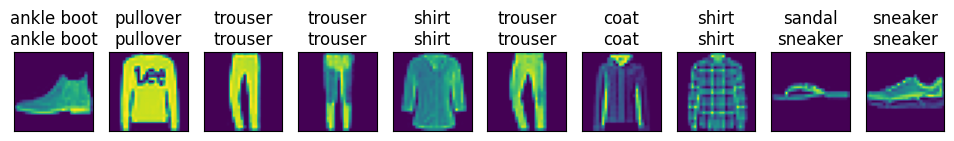

In [21]:
batch_size = 256
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=4)
SMR = SoftMaxRegression()
SMR.run(train_iter,test_iter)

# 2、自己上网调研并实现如何完全基于pytorch提供的函数框架对Fashion-MNIST数据集分类，关键词nn.CrossEntropyLoss()，在实现时你需要自己构建一个骨干网络

In [16]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

参数设置

In [60]:
batch_size = 256
epochs = 5
learning_rate = 0.01

骨干网络构建

In [26]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

接着你要利用nn.CrossEntropyLoss()、优化器（SGD或Adam）、MiniBatch梯度更新策略完成对MyNet的训练

In [35]:
model = MyNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False)

In [52]:
#启用cuda加速
device = torch.device("cpu")
if torch.cuda.is_available():
        device = torch.device("cuda")
print(device, "is available")

cuda is available


训练

In [61]:
model.train(True)
model.to(device)
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        #清零
        optimizer.zero_grad()
        #对于每个类别和输入特征，计算得到其输出值，即对每个训练样本计算每个类别的得分
        output = model(data)
        #计算损失函数
        loss = criterion(output, target)
        # 计算损失函数相对于每个权重向量和偏置的梯度
        loss.backward()
        #更新每个类别的权重和偏置
        optimizer.step()
        
        #每100批次输出一次结果
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}')

Epoch 1/5, Batch 0/235, Loss: 0.19508783519268036
Epoch 1/5, Batch 100/235, Loss: 0.2584953308105469
Epoch 1/5, Batch 200/235, Loss: 0.25965002179145813
Epoch 2/5, Batch 0/235, Loss: 0.2584072947502136
Epoch 2/5, Batch 100/235, Loss: 0.17952196300029755
Epoch 2/5, Batch 200/235, Loss: 0.18141470849514008
Epoch 3/5, Batch 0/235, Loss: 0.2270979881286621
Epoch 3/5, Batch 100/235, Loss: 0.19787482917308807
Epoch 3/5, Batch 200/235, Loss: 0.2589370310306549
Epoch 4/5, Batch 0/235, Loss: 0.22637881338596344
Epoch 4/5, Batch 100/235, Loss: 0.20231546461582184
Epoch 4/5, Batch 200/235, Loss: 0.27125680446624756
Epoch 5/5, Batch 0/235, Loss: 0.20648640394210815
Epoch 5/5, Batch 100/235, Loss: 0.21730664372444153
Epoch 5/5, Batch 200/235, Loss: 0.27523133158683777


预测和精度计算

In [62]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'Accuracy of the network on the test data: {100 * correct / total}%')

Accuracy of the network on the test data: 86.74%


结果可视化(不知道为什么选择10个以上样本显示会反色）

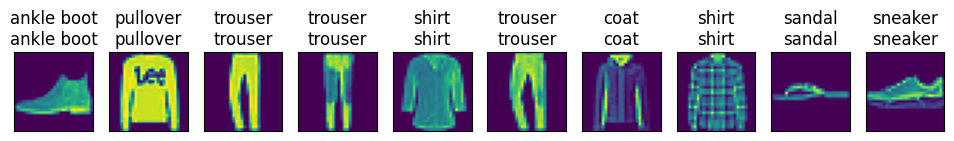

In [88]:
model.eval()
data, target = next(iter(test_loader))
show_nun = 10

# 获取预测结果
with torch.no_grad():
    data_gpu = data.to(device)
    outputs = model(data_gpu)
    _, predicted = torch.max(outputs, 1)

# 获取真实标签和预测标签的文本表示
true_labels = get_fashion_mnist_labels(target)
predicted_labels = get_fashion_mnist_labels(predicted)

# 选择10组样本进行可视化
titles = [true + '\n' + pred for true, pred in zip(true_labels, predicted_labels)] # 真实标签与预测标签
show_fashion_mnist(data[:show_nun], titles[:show_nun])